In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the model
class UnitSquareDetector(nn.Module):
    def __init__(self):
        super(UnitSquareDetector, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # 2 input features (x, y), 10 outputs
        self.fc2 = nn.Linear(10, 1)  # 10 inputs, 1 output (inside/outside)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))  # Sigmoid to get a probability
        return x

model = UnitSquareDetector().to(device)

# Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Generate data
def generate_data(num_samples):
    # Generate random points
    points = np.random.rand(num_samples, 2) * 2
    # Labels: 1 if inside unit square (0 <= x, y <= 1), 0 otherwise
    labels = ((points >= 0) & (points <= 1)).all(axis=1).astype(float)
    return torch.tensor(points, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)

# Training the model
num_epochs = 100
batch_size = 256
num_samples = 100000

# Generating the data
inputs, labels = generate_data(num_samples)
inputs, labels = inputs.to(device), labels.to(device)
dataset = torch.utils.data.TensorDataset(inputs, labels)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop
for epoch in tqdm(range(num_epochs)):
    for i, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.view(-1, 1)  # Reshape labels to match output shape
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

# Model is now trained
"Model training complete."

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [01:54<00:00,  1.14s/it]


'Model training complete.'

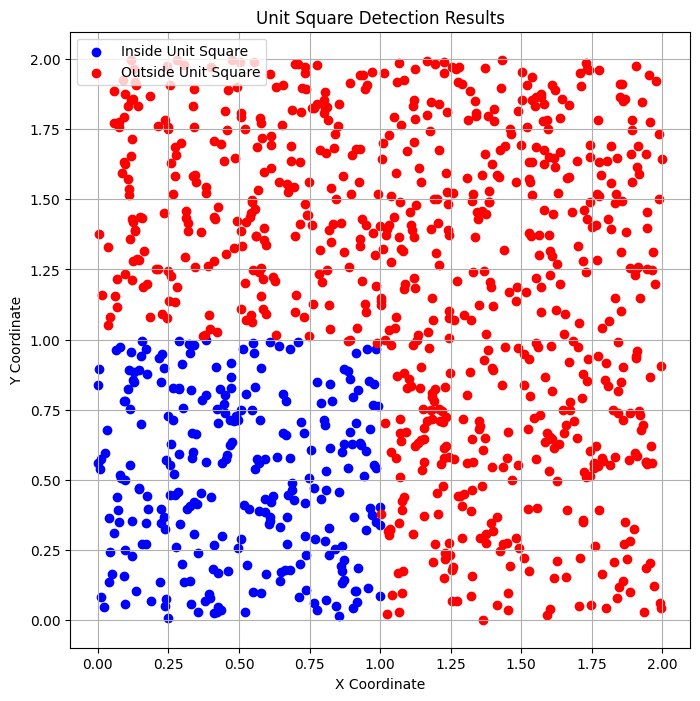

In [8]:
import matplotlib.pyplot as plt

# Generate 1000 random points in the range [0, 2]^2
test_points = np.random.rand(1000, 2) * 2
test_tensor = torch.tensor(test_points, dtype=torch.float32).to(device)

# Use the trained model to predict whether points are inside the unit square
with torch.no_grad():
    predictions = model(test_tensor).cpu().numpy()

# Threshold predictions at 0.5 to classify as inside (>= 0.5) or outside (< 0.5)
classified_points = (predictions >= 0.5).reshape(-1)

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(test_points[classified_points, 0], test_points[classified_points, 1], color='blue', label='Inside Unit Square')
plt.scatter(test_points[~classified_points, 0], test_points[~classified_points, 1], color='red', label='Outside Unit Square')
plt.title('Unit Square Detection Results')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Define the EBM
class UnitSquareEBM(nn.Module):
    def __init__(self):
        super(UnitSquareEBM, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
            nn.ReLU(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        return self.fc(x)

# Initialize EBM
ebm = UnitSquareEBM().to(device)

# Optimizer
optimizer = optim.Adam(ebm.parameters(), lr=0.001)

# Training the EBM
num_epochs = 10000
inside_square_samples = 100
outside_square_samples = 200

for epoch in range(num_epochs):
    # Generate points inside the unit square
    inside_points = (torch.rand(inside_square_samples, 2) - 0.5).to(device)
    
    # Generate random points in the space [0, 2]^2
    outside_points = (torch.rand(outside_square_samples, 2) * 2 - 1).to(device)

    # Forward pass
    inside_energy = ebm(inside_points).mean()
    outside_energy = ebm(outside_points).mean()

    # Loss: Push down on inside energy, push up on outside energy
    loss = torch.relu(outside_energy - inside_energy + 2)

    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# EBM is now trained
"EBM training complete."

'EBM training complete.'

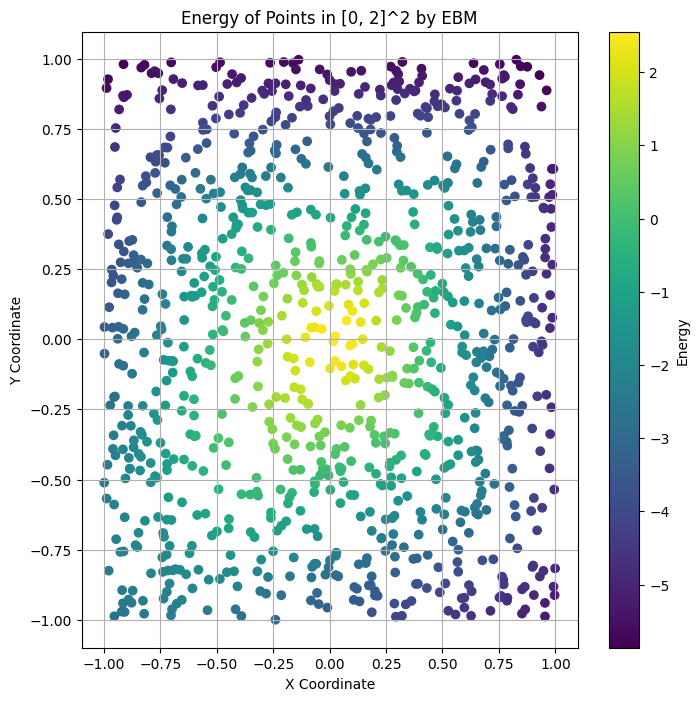

'Energy plot for [0, 2]^2 complete.'

In [53]:
# Generating points in [0, 2]^2 for plotting energy
plot_points = (torch.rand(1000, 2) * 2 - 1).to(device)

# Calculate the energy for these points using the trained EBM
with torch.no_grad():
    plot_energy = ebm(plot_points).cpu().numpy().flatten()

# Plotting
plt.figure(figsize=(8, 8))
sc = plt.scatter(plot_points.cpu()[:, 0], plot_points.cpu()[:, 1], c=plot_energy, cmap='viridis')
plt.colorbar(sc, label='Energy')
plt.title('Energy of Points in [0, 2]^2 by EBM')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

# Indicate that the plot is complete
"Energy plot for [0, 2]^2 complete."


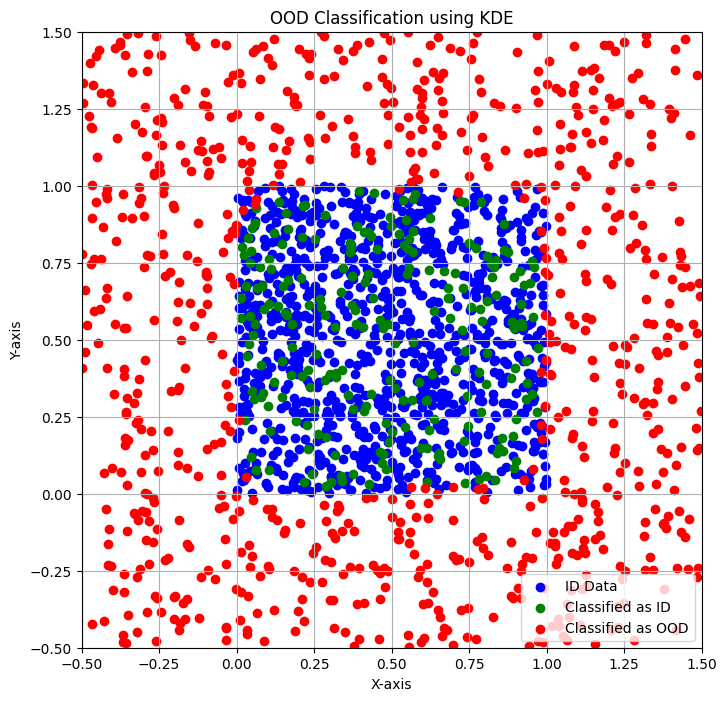

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity

# Generate ID data points within the unit square
n_id_points = 10000
id_data = np.random.uniform(0, 1, (n_id_points, 2))

# Fit KDE to ID data
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(id_data)

# Generate test points
n_test_points = 1000
test_data = np.random.uniform(-0.5, 1.5, (n_test_points, 2))

# Compute log density scores
log_dens = kde.score_samples(test_data)
density_threshold = np.percentile(kde.score_samples(id_data), 10)  # Threshold at the 10th percentile

# Classify as ID or OOD
is_id = log_dens > density_threshold

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(id_data[:1000, 0], id_data[:1000, 1], c='blue', label='ID Data')
plt.scatter(test_data[is_id, 0], test_data[is_id, 1], c='green', label='Classified as ID')
plt.scatter(test_data[~is_id, 0], test_data[~is_id, 1], c='red', label='Classified as OOD')
plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)
plt.title('OOD Classification using KDE')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.grid(True)
plt.show()
